# Define Success Metrics - USA companies only
Define what constitutes "success" for a startup based on available data. This could be based on status (acquired, IPO), funding_total_usd, age, or a combination of factors. This step is crucial as it establishes our target variable for prediction.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the companies dataset
print("Loading companies dataset...")
companies_df = pd.read_csv('usa_cleaned_companies.csv', low_memory=False)
print(f"Dataset loaded with {companies_df.shape[0]} rows and {companies_df.shape[1]} columns")

Loading companies dataset...
Dataset loaded with 51637 rows and 19 columns


In [2]:
# Convert date columns to datetime format
date_columns = ['founded_at', 'closed_at', 'first_investment_at', 'last_investment_at', 
               'first_funding_at', 'last_funding_at', 'first_milestone_at', 
               'last_milestone_at', 'created_at', 'updated_at']

for col in date_columns:
    if col in companies_df.columns:
        companies_df[col] = pd.to_datetime(companies_df[col], errors='coerce')
        print(f"Converted {col} to datetime")

Converted founded_at to datetime
Converted first_funding_at to datetime
Converted last_funding_at to datetime
Converted first_milestone_at to datetime
Converted last_milestone_at to datetime
Converted created_at to datetime
Converted updated_at to datetime


In [3]:
# Examine the status distribution to understand potential success indicators
status_counts = companies_df['status'].value_counts()
print("\nCompany Status Distribution:")
print(status_counts)
print(f"\nPercentage of companies by status:")
print(status_counts / status_counts.sum() * 100)

# Visualize the status distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='status', data=companies_df, order=companies_df['status'].value_counts().index)
plt.title('Distribution of Company Status')
plt.tight_layout()
plt.savefig('status_distribution.png')
plt.show
plt.close()


Company Status Distribution:
status
operating    44388
acquired      4974
closed        1354
ipo            921
Name: count, dtype: int64

Percentage of companies by status:
status
operating   85.96
acquired     9.63
closed       2.62
ipo          1.78
Name: count, dtype: float64


35.13% of USA companies have funding data (in contrast to 14% of all)


Funding Statistics (USD):
count        18142.00
mean      17119856.21
std       78026329.50
min            291.00
25%         750000.00
50%        3500000.00
75%       13950000.00
max     5700000000.00
Name: funding_total_usd, dtype: float64

Funding Quartiles (USD):
0.25      750000.00
0.50     3500000.00
0.75    13950000.00
0.90    40000000.00
0.95    66000000.00
0.99   191795000.00
Name: funding_total_usd, dtype: float64


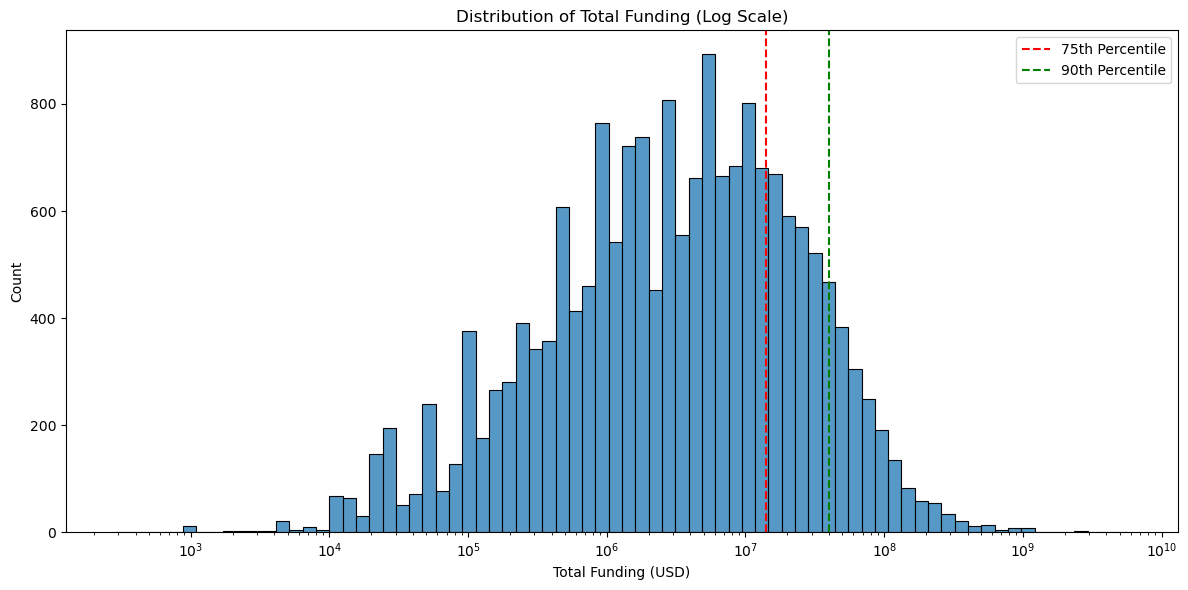

In [4]:
# Examine funding distribution for companies with funding data
funding_stats = companies_df['funding_total_usd'].describe()
print("\nFunding Statistics (USD):")
print(funding_stats)

# Calculate funding quartiles for companies with funding data
companies_with_funding = companies_df[companies_df['funding_total_usd'].notna()]
funding_quartiles = companies_with_funding['funding_total_usd'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nFunding Quartiles (USD):")
print(funding_quartiles)

# Visualize funding distribution (log scale due to high skew)
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_funding['funding_total_usd'], log_scale=True)
plt.title('Distribution of Total Funding (Log Scale)')
plt.xlabel('Total Funding (USD)')
plt.axvline(funding_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.axvline(funding_quartiles[0.9], color='g', linestyle='--', label='90th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('funding_distribution.png')
plt.show()


Company Age Statistics (years):
count   38625.00
mean       18.30
std        10.74
min         9.00
25%        12.17
50%        15.00
75%        21.00
max       122.00
Name: age_years, dtype: float64

Age Quartiles (years):
0.25   12.17
0.50   15.00
0.75   21.00
0.90   27.00
Name: age_years, dtype: float64


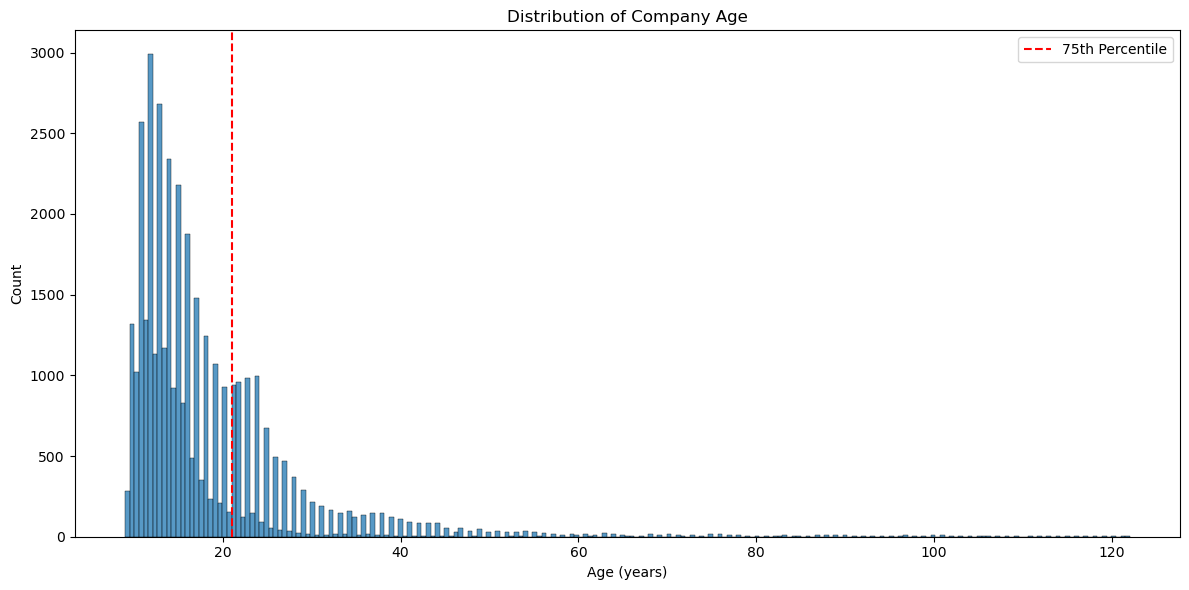

In [5]:
# Calculate company age for companies with founding date
current_date = pd.Timestamp('2023-01-01')  # Using a fixed date as "current" for consistency

# Create age_years column directly from the calculation, which will ensure proper numeric dtype
# For companies without a founding date, NaN will be used (which preserves numeric dtype)
mask = companies_df['founded_at'].notna()
companies_df['age_years'] = np.nan  # Initialize with NaN instead of None to maintain float dtype
companies_df.loc[mask, 'age_years'] = (
    (current_date - companies_df.loc[mask, 'founded_at']).dt.days / 365.25
)

# Print age statistics
age_stats = companies_df['age_years'].describe()
print("\nCompany Age Statistics (years):")
print(age_stats)

# Calculate age quartiles
companies_with_age = companies_df[companies_df['age_years'].notna()]
age_quartiles = companies_with_age['age_years'].quantile([0.25, 0.5, 0.75, 0.9])
print("\nAge Quartiles (years):")
print(age_quartiles)

# Visualize age distribution
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_age['age_years'])
plt.title('Distribution of Company Age')
plt.xlabel('Age (years)')
plt.axvline(age_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()

In [6]:
# Define success metrics based on our analysis

# 1. Status-based success (acquired or IPO)
companies_df['success_status'] = companies_df['status'].apply(
    lambda x: 1 if x in ['acquired', 'ipo'] else 0
)

# Print status-based success distribution
print("\nStatus-based Success Distribution:")
status_success_counts = companies_df['success_status'].value_counts()
print(status_success_counts)
print(f"Percentage successful: {status_success_counts[1] / status_success_counts.sum() * 100:.2f}%")

# 2. Funding-based success (top 25% of funded companies)
# First, determine the 75th percentile funding threshold
funding_threshold = funding_quartiles[0.75]
print(f"\nFunding threshold for success (75th percentile): ${funding_threshold:,.2f}")

# Create funding-based success metric
companies_df['success_funding'] = 0  # Default to 0 (not successful)
mask = companies_df['funding_total_usd'] >= funding_threshold
companies_df.loc[mask, 'success_funding'] = 1

# Print funding-based success distribution
print("\nFunding-based Success Distribution:")
funding_success_counts = companies_df['success_funding'].value_counts()
print(funding_success_counts)
print(f"Percentage successful: {funding_success_counts[1] / companies_df.shape[0] * 100:.2f}%")
print(f"Percentage with funding data: {companies_with_funding.shape[0] / companies_df.shape[0] * 100:.2f}%")

# 3. Longevity-based success (companies older than 75th percentile)
age_threshold = age_quartiles[0.75]
print(f"\nAge threshold for success (75th percentile): {age_threshold:.2f} years")

# Create age-based success metric
companies_df['success_age'] = 0  # Default to 0 (not successful)
mask = companies_df['age_years'] >= age_threshold
companies_df.loc[mask, 'success_age'] = 1

# Print age-based success distribution
print("\nAge-based Success Distribution:")
age_success_counts = companies_df['success_age'].value_counts()
print(age_success_counts)
print(f"Percentage successful: {age_success_counts[1] / companies_df.shape[0] * 100:.2f}%")
print(f"Percentage with age data: {companies_with_age.shape[0] / companies_df.shape[0] * 100:.2f}%")


Status-based Success Distribution:
success_status
0    45742
1     5895
Name: count, dtype: int64
Percentage successful: 11.42%

Funding threshold for success (75th percentile): $13,950,000.00

Funding-based Success Distribution:
success_funding
0    47100
1     4537
Name: count, dtype: int64
Percentage successful: 8.79%
Percentage with funding data: 35.13%

Age threshold for success (75th percentile): 21.00 years

Age-based Success Distribution:
success_age
0    41831
1     9806
Name: count, dtype: int64
Percentage successful: 18.99%
Percentage with age data: 74.80%



Composite Success Score Distribution:
success_score
0    35404
1     8385
2     1563
3     3575
4     2096
5      459
6      155
Name: count, dtype: int64


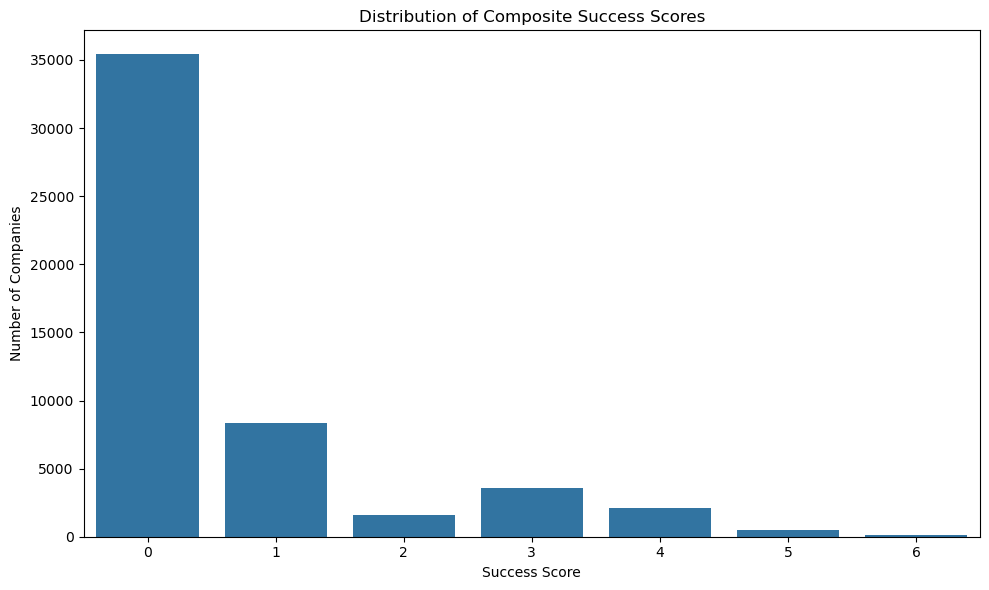

In [7]:
# Create a composite success metric combining multiple factors

# Define a function to assign a composite success score
def assign_composite_success(row):
    score = 0

    # Status-based component (highest weight)
    if row['status'] in ['acquired', 'ipo']:
        score += 3

    # Funding-based component
    if pd.notna(row['funding_total_usd']):
        if row['funding_total_usd'] >= funding_quartiles[0.9]:  # Top 10%
            score += 2
        elif row['funding_total_usd'] >= funding_quartiles[0.75]:  # Top 25%
            score += 1

    # Age-based component
    if pd.notna(row['age_years']):
        if row['age_years'] >= age_quartiles[0.75]:  # Top 25%
            score += 1

    return score

# Apply the composite scoring function
companies_df['success_score'] = companies_df.apply(assign_composite_success, axis=1)

# Print composite score distribution
print("\nComposite Success Score Distribution:")
score_counts = companies_df['success_score'].value_counts().sort_index()
print(score_counts)

# Visualize the score distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='success_score', data=companies_df, order=sorted(companies_df['success_score'].unique()))
plt.title('Distribution of Composite Success Scores')
plt.xlabel('Success Score')
plt.ylabel('Number of Companies')
plt.tight_layout()
plt.savefig('success_score_distribution.png')
plt.show()


Binary Success Label Distribution based on the Composite Score:
success_binary
0    35404
1    16233
Name: count, dtype: int64
Percentage successful: 31.44%

Multi-class Success Label Distribution based on the Composite Score:
success_class
unsuccessful        35404
low_success          8385
high_success         6285
moderate_success     1563
Name: count, dtype: int64
Percentage unsuccessful: 68.56%
Percentage low_success: 16.24%
Percentage high_success: 12.17%
Percentage moderate_success: 3.03%


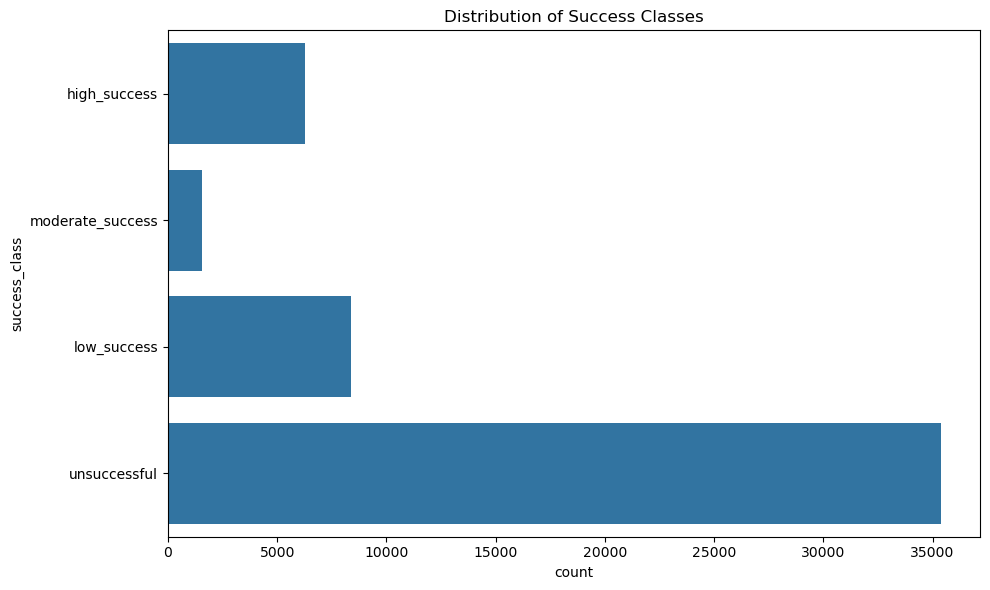

In [8]:
# Create binary and multi-class success labels based on the composite score

# Binary success label (score of 1 or higher considered successful)
success_threshold = 1
companies_df['success_binary'] = (companies_df['success_score'] >= success_threshold).astype(int)

# Print binary success distribution
print("\nBinary Success Label Distribution based on the Composite Score:")
binary_counts = companies_df['success_binary'].value_counts()
print(binary_counts)
print(f"Percentage successful: {binary_counts[1] / binary_counts.sum() * 100:.2f}%")

# Multi-class success label
def assign_success_class(score):
    if score >= 3:
        return 'high_success'
    elif score == 2:
        return 'moderate_success'
    elif score == 1:
        return 'low_success'
    else:
        return 'unsuccessful'

companies_df['success_class'] = companies_df['success_score'].apply(assign_success_class)

# Print multi-class success distribution
print("\nMulti-class Success Label Distribution based on the Composite Score:")
class_counts = companies_df['success_class'].value_counts()
print(class_counts)
for class_name, count in class_counts.items():
    print(f"Percentage {class_name}: {count / class_counts.sum() * 100:.2f}%")

# Visualize the multi-class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='success_class', data=companies_df, 
              order=['high_success', 'moderate_success', 'low_success', 'unsuccessful'])
plt.title('Distribution of Success Classes')
plt.tight_layout()
plt.savefig('success_class_distribution.png')
plt.show()


Success Rates by Top Categories:
               success_binary  success_status  success_funding
category_code                                                 
biotech                  0.49            0.17             0.28
enterprise               0.40            0.15             0.18
software                 0.38            0.14             0.08
consulting               0.31            0.05             0.02
advertising              0.27            0.09             0.08
other                    0.26            0.05             0.01
games_video              0.23            0.11             0.07
ecommerce                0.22            0.05             0.04
mobile                   0.22            0.11             0.08
web                      0.21            0.11             0.04


<Figure size 1200x800 with 0 Axes>

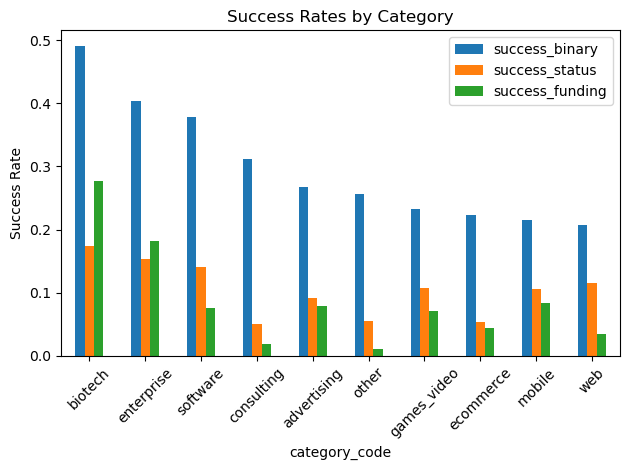

In [9]:
# Analyze success metrics by category_code to understand industry-specific patterns
# This can help validate our success definitions

# Get top 10 categories by count
top_categories = companies_df['category_code'].value_counts().head(10).index

# Calculate success rate by category
category_success = companies_df[companies_df['category_code'].isin(top_categories)].groupby('category_code')[
    ['success_binary', 'success_status', 'success_funding']
].mean()

print("\nSuccess Rates by Top Categories:")
print(category_success.sort_values('success_binary', ascending=False))

# Visualize success rates by category
plt.figure(figsize=(12, 8))
category_success.sort_values('success_binary', ascending=False).plot(kind='bar')
plt.title('Success Rates by Category')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('category_success_rates.png')
plt.show()

In [10]:
# Save the dataset with success labels
output_file = 'usa_companies_with_success_labels.csv'
print(f"\nSaving dataset with success labels to {output_file}...")
companies_df.to_csv(output_file, index=False)
print(f"Saved {companies_df.shape[0]} rows with success metrics")


Saving dataset with success labels to usa_companies_with_success_labels.csv...
Saved 51637 rows with success metrics


In [15]:
# Create a detailed report on the success metrics definition
report_content = """# Success Metrics Definition Report

## Overview
This report documents how success metrics were defined for the startup analysis project using the Crunchbase dataset. Multiple success metrics were created to capture different aspects of startup success, and a composite metric was developed to provide a more comprehensive measure.

## Data Availability Challenges
- Funding data available for {funding_pct:.2f}% of companies
- Founding date available for {age_pct:.2f}% of companies

## Success Metrics Defined

### 1. Status-based Success
- **Definition**: Companies with status 'acquired' or 'ipo'
- **Rationale**: Acquisition or IPO represents a clear exit event and is widely recognized as a successful outcome
- **Coverage**: 100% of companies have status data
- **Success Rate**: {status_success_pct:.2f}% of companies are successful by this metric

### 2. Funding-based Success
- **Definition**: Companies with total funding in the top quartile (≥ ${funding_threshold:,.2f})
- **Rationale**: Attracting significant funding indicates investor confidence and market validation
- **Coverage**: {funding_pct:.2f}% of companies have funding data
- **Success Rate**: {funding_success_pct:.2f}% of all companies are successful by this metric

### 4. Longevity-based Success
- **Definition**: Companies operating for {age_threshold:.2f}+ years
- **Rationale**: Surviving for an extended period indicates business sustainability
- **Coverage**: {age_pct:.2f}% of companies have age data
- **Success Rate**: {age_success_pct:.2f}% of all companies are successful by this metric

## Composite Success Metric

A composite success score was created by combining multiple factors:

- **Status Component**: 3 points for acquired/IPO companies
- **Funding Component**: 
  - 2 points for top 10% in funding
  - 1 point for top 25% in funding
- **Age Component**: 1 point for companies in the top quartile of age

### Success Score Distribution
{score_distribution}

### Binary Success Classification
- **Definition**: Companies with a success score ≥ {success_threshold}
- **Success Rate**: {binary_success_pct:.2f}% of companies classified as successful

### Multi-class Success Classification
- **High Success**: Score ≥ 3
- **Moderate Success**: Score = 2
- **Low Success**: Score = 1
- **Unsuccessful**: Score = 0

### Multi-class Distribution
{class_distribution}

## Industry-specific Success Patterns

Success rates vary significantly by industry category:

{category_success_rates}

## Conclusion

The composite success metric provides a balanced approach to measuring startup success, accounting for multiple dimensions while handling the challenge of missing data. The binary and multi-class labels derived from this metric will serve as target variables for predictive modeling in subsequent analysis steps.
""".format(
    funding_pct=len(companies_with_funding) / len(companies_df) * 100,
    age_pct=len(companies_with_age) / len(companies_df) * 100,
    status_success_pct=status_success_counts[1] / status_success_counts.sum() * 100 if 1 in status_success_counts else 0,
    funding_threshold=funding_threshold,
    funding_success_pct=funding_success_counts[1] / companies_df.shape[0] * 100 if 1 in funding_success_counts else 0,
    age_threshold=age_threshold,
    age_success_pct=age_success_counts[1] / companies_df.shape[0] * 100 if 1 in age_success_counts else 0,
    score_distribution=score_counts.to_string(),
    success_threshold=success_threshold,
    binary_success_pct=binary_counts[1] / binary_counts.sum() * 100 if 1 in binary_counts else 0,
    class_distribution=class_counts.to_string(),
    category_success_rates=category_success.sort_values('success_binary', ascending=False).to_string()
)

# Save the report
report_file = 'usa_success_metrics_report.md'
with open(report_file, 'w') as f:
    f.write(report_content)

print(f"Success metrics report saved to {report_file}")
print("\nSuccess metrics definition complete!")

Success metrics report saved to usa_success_metrics_report.md

Success metrics definition complete!
